In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

import matplotlib.pyplot as plt

from tqdm import trange
from copy import deepcopy

In [2]:
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')

In [3]:
train_data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
for i in range(10):
    print(f"class {i} size:", len(train_data[train_data["label"] == i]))

class 0 size: 5923
class 1 size: 6742
class 2 size: 5958
class 3 size: 6131
class 4 size: 5842
class 5 size: 5421
class 6 size: 5918
class 7 size: 6265
class 8 size: 5851
class 9 size: 5949


In [5]:
train_data_1 = train_data[train_data["label"] == 1]
train_data_0 = train_data[train_data["label"] != 1]
train_data = None

test_data_1 = test_data[test_data["label"] == 1]
test_data_0 = test_data[test_data["label"] != 1]
test_data = None

In [6]:
train_data_0.shape, train_data_1.shape, test_data_0.shape, test_data_1.shape

((53258, 785), (6742, 785), (8865, 785), (1135, 785))

In [7]:
train_1_array = train_data_1.to_numpy()
train_0_array = train_data_0.to_numpy()

train_1_labels = train_1_array[:, 0]
train_0_labels = np.array([0] * train_0_array.shape[0])

train_1_array = train_1_array[:, 1:]
train_0_array = train_0_array[:, 1:]

print(train_1_array.shape, train_0_array.shape)

test_1_array = test_data_1.to_numpy()
test_0_array = test_data_0.to_numpy()

test_1_labels = test_1_array[:, 0]
test_0_labels = np.array([0] * test_0_array.shape[0])

test_1_array = test_1_array[:, 1:]
test_0_array = test_0_array[:, 1:]

print(test_1_array.shape, test_0_array.shape)

(6742, 784) (53258, 784)
(1135, 784) (8865, 784)


In [8]:
train_1_array = train_1_array.reshape(-1, 28, 28)
train_0_array = train_0_array.reshape(-1, 28, 28)

test_1_array = test_1_array.reshape(-1, 28, 28)
test_0_array = test_0_array.reshape(-1, 28, 28)

In [9]:
train_1_array.shape, train_0_array.shape, test_1_array.shape, test_0_array.shape

((6742, 28, 28), (53258, 28, 28), (1135, 28, 28), (8865, 28, 28))

In [10]:
# random 1 values from 0 to len(data_1_array)
random_values = np.random.randint(0, len(train_1_array), 1)

# train pool split
train_1, train_1_y = train_1_array[random_values], train_1_labels[random_values]
pool_1, pool_1_y = np.delete(train_1_array, random_values, axis=0), np.delete(train_1_labels, random_values, axis=0)

# random 1 values from 0 to len(data_0_array)
random_values = np.random.randint(0, len(train_0_array), 1)

# train pool split
train_0, train_0_y = train_0_array[random_values], train_0_labels[random_values]
pool_0, pool_0_y = np.delete(train_0_array, random_values, axis=0), np.delete(train_0_labels, random_values, axis=0)

In [11]:
pool_1.shape, pool_1_y.shape, pool_0.shape, pool_0_y.shape

((6741, 28, 28), (6741,), (53257, 28, 28), (53257,))

In [12]:
test_0_labels.shape, test_1_labels.shape

((8865,), (1135,))

In [13]:
pool = np.concatenate((pool_1, pool_0), axis=0)
pool_y = np.concatenate((pool_1_y, pool_0_y), axis=0)

pool.shape, pool_y.shape

((59998, 28, 28), (59998,))

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 2, 3)
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x, features=False):
        x = x.view(-1, 1, 28, 28)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 2)
        if features:
            return x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [15]:
def train(model, optimizer, criterion, train_X, train_y, epochs=5):
    model.train()
    losses = []
    accuracy = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(train_X)
        output = torch.cat((1 - output, output), 1)

        loss = criterion(output, train_y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = torch.round(output)
        
        true_positives = torch.sum(torch.logical_and(pred[:, 1] == 1, train_y[:, 1] == 1)).item()
        true_negatives = torch.sum(torch.logical_and(pred[:, 0] == 1, train_y[:, 0] == 1)).item()
        false_positives = torch.sum(torch.logical_and(pred[:, 1] == 1, train_y[:, 0] == 1)).item()
        false_negatives = torch.sum(torch.logical_and(pred[:, 0] == 1, train_y[:, 1] == 1)).item()

        # accuracy_value = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        accuracy.append((true_positives, true_negatives, false_positives, false_negatives))
    
    accuracy = np.array(accuracy)

    return losses, accuracy, output

In [16]:
def eval(model, criterion, test_X, test_y):
    model.eval()
    with torch.no_grad():
        output = model(test_X)
        output = torch.cat((1 - output, output), 1)
        loss = criterion(output, test_y)
        pred = torch.round(output)

        true_positives = torch.sum(torch.logical_and(pred[:, 1] == 1, test_y[:, 1] == 1)).item()
        true_negatives = torch.sum(torch.logical_and(pred[:, 0] == 1, test_y[:, 0] == 1)).item()
        false_positives = torch.sum(torch.logical_and(pred[:, 1] == 1, test_y[:, 0] == 1)).item()
        false_negatives = torch.sum(torch.logical_and(pred[:, 0] == 1, test_y[:, 1] == 1)).item()

        accuracy = (true_positives, true_negatives, false_positives, false_negatives)
        
    return loss.item(), accuracy, output

In [17]:
model = Model()
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [18]:
train_X = np.concatenate((train_0, train_1), axis=0)
train_X = torch.from_numpy(train_X).float()
train_y = np.concatenate((train_0_y, train_1_y), axis=0)
train_y = torch.from_numpy(train_y).float()
train_y = F.one_hot(train_y.to(torch.int64), num_classes=2).float()

train_X.shape, train_y.shape

(torch.Size([2, 28, 28]), torch.Size([2, 2]))

In [19]:
losses, accuracy, pred = train(model, optimizer, criterion, train_X, train_y)

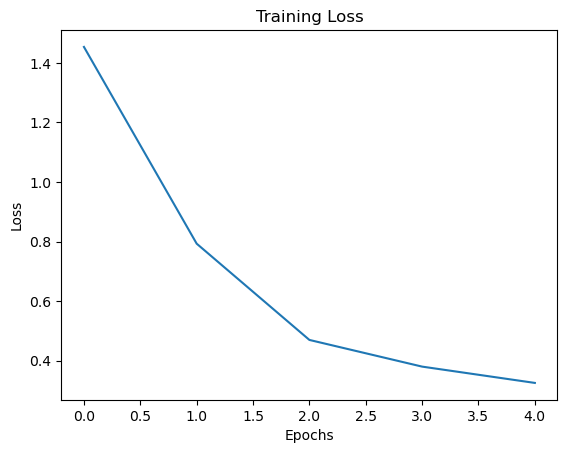

In [29]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

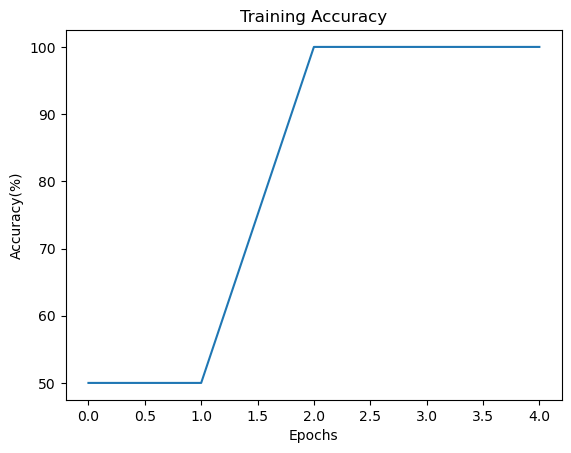

In [28]:
plt.plot(100*(accuracy[:, 0]+accuracy[:, 1])/(accuracy[:, 0]+accuracy[:, 1]+accuracy[:, 2]+accuracy[:, 3]))
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.title("Training Accuracy")
plt.show()

# Active Learning

In [30]:
def centroid(model, train_x, pool_x, pool_y, ranks=False):
    features = model(train_x, features=True)
    centroid_feature = torch.mean(features, dim=0)
    pool_features = model(pool_x, features=True)

    distance = torch.cdist(pool_features, centroid_feature.reshape(1, -1))
    
    n_max_idx = torch.argmax(distance)

    if ranks:
        distance_ranks = torch.argsort(distance.reshape(-1))

        return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx], distance_ranks.reshape(-1)
    
    return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx]


def farthest(model, train_x, pool_x, pool_y, ranks=False):
    features = model(train_x, features=True)
    pool_features = model(pool_x, features=True)
    distances = torch.cdist(pool_features, features)
    farthest = torch.max(distances, dim=1)
    n_max_idx = torch.argmax(farthest.values)

    if ranks:
        distance_ranks = torch.argsort(farthest.values)

        return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx], distance_ranks.reshape(-1)
    
    return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx]


def closest(model, train_x, pool_x, pool_y, ranks=False):
    features = model(train_x, features=True)
    pool_features = model(pool_x, features=True)
    distances = torch.cdist(pool_features, features)
    closest = torch.min(distances, dim=1)
    n_max_idx = torch.argmax(closest.values)

    if ranks:
        distance_ranks = torch.argsort(closest.values)

        return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx], distance_ranks.reshape(-1)
    
    return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx]


def entropy(model, pool_x, pool_y, ranks=False):
    p = model(pool_x)

    entropy = torch.where((p == 0) | (p == 1), torch.zeros_like(p), -p*torch.log2(p) - (1-p)*torch.log2(1-p)).reshape(-1)

    n_max_idx = torch.argmax(entropy)

    if ranks:
        entropy_ranks = torch.argsort(entropy)

        return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx], entropy_ranks
    
    return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx]


def compare_ranks(ranks1, ranks2):
    added = ranks1.reshape(-1) + ranks2.reshape(-1)

    min_rank, min_idx = torch.min(added, dim=0)

    return min_rank, min_idx

In [31]:
# test compare ranks
ranks1 = torch.tensor([10, 2, 3, 4, 5])
ranks2 = torch.tensor([5, 4, 3, 2, 1])

compare_ranks(ranks1, ranks2)

(tensor(6), tensor(1))

In [32]:
def test(model, criterion):
    test_X = np.concatenate((test_0_array, test_1_array), axis=0)
    test_X = torch.from_numpy(test_X).float()
    test_y = np.concatenate((test_0_labels, test_1_labels), axis=0)
    test_y = torch.from_numpy(test_y).float()
    test_y = F.one_hot(test_y.to(torch.int64), num_classes=2).float()

    loss, acc, _ = eval(model, criterion, test_X, test_y)

    return loss, acc

In [33]:
train_X = np.concatenate((train_0, train_1), axis=0)
train_X = torch.from_numpy(train_X).float()
train_y = np.concatenate((train_0_y, train_1_y), axis=0)
train_y = torch.from_numpy(train_y).float()
train_y = F.one_hot(train_y.to(torch.int64), num_classes=2).float()

pool_X = np.concatenate((pool_0, pool_1), axis=0)
pool_X = torch.from_numpy(pool_X).float()
pool_y = np.concatenate((pool_0_y, pool_1_y), axis=0)
pool_y = torch.from_numpy(pool_y).float()
pool_y = F.one_hot(pool_y.to(torch.int64), num_classes=2).float()

In [34]:
losses = [[], [], []]
accuracy = [[], [], []]
ac_f = {1: centroid, 2: farthest, 3: closest}

In [35]:
for i in range(3):
    print(f"Active Learning Method: {i+1} ------------------------------")
    f = ac_f[i+1]

    model = Model()
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    t_x = deepcopy(train_X)
    t_y = deepcopy(train_y)
    p_x = deepcopy(pool_X)
    p_y = deepcopy(pool_y)
    
    for j in trange(30):
        _, _, _ = train(model, optimizer, criterion, t_x, t_y)
        loss, acc = test(model, criterion)

        losses[i].append(loss)
        accuracy[i].append(100*(acc[0]+acc[1])/(acc[0] + acc[1] + acc[2] + acc[3]))

        _, _, _, ranks1 = f(model, t_x, p_x, p_y, ranks=True)
        _, _, _, ranks2 = entropy(model, p_x, p_y, ranks=True)

        min_rank, ind = compare_ranks(ranks1, ranks2)

        t_x = torch.cat((t_x, p_x[ind].reshape(-1, 28, 28)), dim=0)
        t_y = torch.cat((t_y, p_y[ind].reshape(-1, 2)), dim=0)

        p_x = torch.cat((p_x[:ind], p_x[ind+1:]), dim=0)
        p_y = torch.cat((p_y[:ind], p_y[ind+1:]), dim=0)

        # print(f"Epoch {j+1} - Loss: {losses[i][-1]} - Accuracy: {accuracy[i][-1]}%")

Active Learning Method: 1 ------------------------------


100%|██████████| 30/30 [01:21<00:00,  2.70s/it]


Active Learning Method: 2 ------------------------------


100%|██████████| 30/30 [01:21<00:00,  2.71s/it]


Active Learning Method: 3 ------------------------------


100%|██████████| 30/30 [01:11<00:00,  2.38s/it]


In [36]:
random_losses = []
random_accuracy = []

In [37]:
for i in range(10):
    r_losses = []
    r_accuracy = []
    print(f"Random {i+1} ------------------------------")

    model = Model()
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    t_x = deepcopy(train_X)
    t_y = deepcopy(train_y)
    p_x = deepcopy(pool_X)
    p_y = deepcopy(pool_y)

    for j in trange(30):
        _, _, _ = train(model, optimizer, criterion, t_x, t_y)
        loss, acc = test(model, criterion)

        r_losses.append(loss)
        r_accuracy.append(100*(acc[0]+acc[1])/(acc[0] + acc[1] + acc[2] + acc[3]))
        
        ind = np.random.randint(0, len(p_x))

        t_x = torch.cat((t_x, p_x[ind].reshape(-1, 28, 28)), dim=0)
        t_y = torch.cat((t_y, p_y[ind].reshape(-1, 2)), dim=0)

        p_x = torch.cat((p_x[:ind], p_x[ind+1:]), dim=0)
        p_y = torch.cat((p_y[:ind], p_y[ind+1:]), dim=0)

        # print(f"Epoch {j+1} - Loss: {r_losses[-1]} - Accuracy: {r_accuracy[-1]}%")

    random_losses.append(r_losses)
    random_accuracy.append(r_accuracy)

Random 1 ------------------------------


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:06<00:00,  4.91it/s]


Random 2 ------------------------------


100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Random 3 ------------------------------


100%|██████████| 30/30 [00:05<00:00,  5.19it/s]


Random 4 ------------------------------


100%|██████████| 30/30 [00:05<00:00,  5.15it/s]


Random 5 ------------------------------


100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Random 6 ------------------------------


100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Random 7 ------------------------------


100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Random 8 ------------------------------


100%|██████████| 30/30 [00:05<00:00,  5.17it/s]


Random 9 ------------------------------


100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


Random 10 ------------------------------


100%|██████████| 30/30 [00:05<00:00,  5.03it/s]


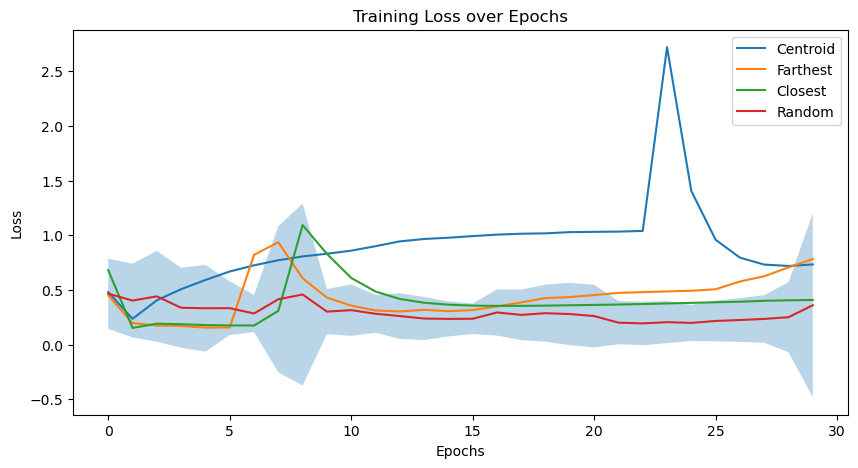

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(losses[0], label="Centroid")
plt.plot(losses[1], label="Farthest")
plt.plot(losses[2], label="Closest")
plt.plot(np.mean(random_losses, axis=0), label="Random")
plt.fill_between(np.arange(30), np.mean(random_losses, axis=0) - 1.645*np.std(random_losses, axis=0), np.mean(random_losses, axis=0) + 1.645*np.std(random_losses, axis=0), alpha=0.3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

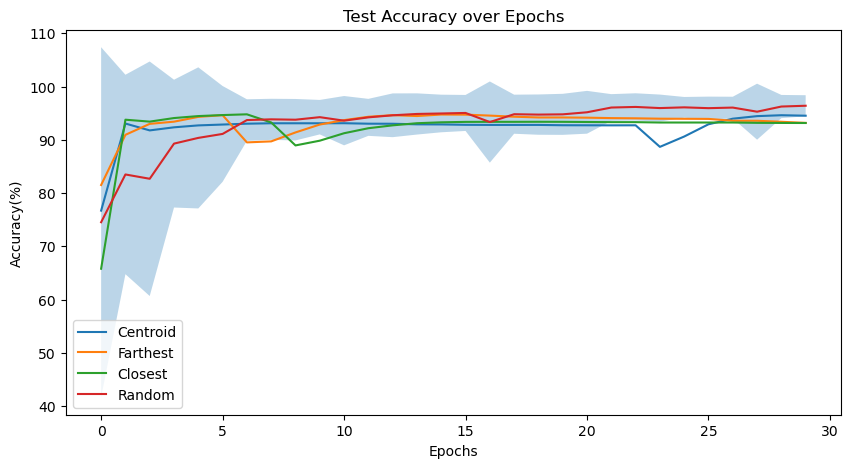

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy[0], label="Centroid")
plt.plot(accuracy[1], label="Farthest")
plt.plot(accuracy[2], label="Closest")
plt.plot(np.mean(random_accuracy, axis=0), label="Random")
plt.fill_between(np.arange(30), np.mean(random_accuracy, axis=0) - 1.645*np.std(random_accuracy, axis=0), np.mean(random_accuracy, axis=0) + 1.645*np.std(random_accuracy, axis=0), alpha=0.3)
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.show()